In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL

### Loading Dataset

In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)

In [3]:
import pathlib
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))

### Converting images to numpy array

In [4]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [5]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [6]:
classes=['roses','daisy','dandelion','sunflowers','tulips']

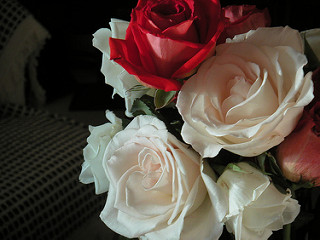

In [7]:
PIL.Image.open(str(flowers_images_dict['roses'][1]))

In [8]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))
img.shape

(240, 179, 3)

In [9]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(180,180))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [14]:
X = np.array(X)
y = np.array(y)

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [16]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

### Implementing the model

In [17]:
cnn = models.Sequential([
    layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same',activation='relu', input_shape=(180,180,3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same',activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same',activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')
])

In [18]:
cnn.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [61]:
cnn.fit(X_train_scaled, y_train, epochs=30)

Epoch 1/30
86/86 [==============================] - 98s 1s/step - loss: 0.8708 - accuracy: 0.6693
Epoch 2/30
86/86 [==============================] - 95s 1s/step - loss: 0.8268 - accuracy: 0.6904
Epoch 3/30
86/86 [==============================] - 85s 989ms/step - loss: 0.7914 - accuracy: 0.7020
Epoch 4/30
86/86 [==============================] - 86s 998ms/step - loss: 0.7834 - accuracy: 0.6999
Epoch 5/30
86/86 [==============================] - 87s 1s/step - loss: 0.7292 - accuracy: 0.7235
Epoch 6/30
86/86 [==============================] - 86s 995ms/step - loss: 0.7121 - accuracy: 0.7376
Epoch 7/30
86/86 [==============================] - 85s 984ms/step - loss: 0.6722 - accuracy: 0.7471
Epoch 8/30
86/86 [==============================] - 85s 993ms/step - loss: 0.6366 - accuracy: 0.7569
Epoch 9/30
86/86 [==============================] - 86s 998ms/step - loss: 0.6077 - accuracy: 0.7758
Epoch 10/30
86/86 [==============================] - 85s 986ms/step - loss: 0.5488 - accuracy: 0.802

In [62]:
cnn.evaluate(X_test_scaled,y_test)

29/29 [==============================] - 9s 296ms/step - loss: 1.4433 - accuracy: 0.6383


[1.443349838256836, 0.6383442282676697]

In [75]:
from sklearn.metrics import confusion_matrix , classification_report
y_pred=cnn.predict(X_test_scaled)
y_pred_classes = [np.argmax(element) for element in y_pred]
print("Classification Report for ANN: \n", classification_report(y_test, y_pred_classes))

Classification Report for ANN: 
               precision    recall  f1-score   support

           0       0.63      0.45      0.52       176
           1       0.64      0.62      0.63       154
           2       0.72      0.69      0.71       226
           3       0.65      0.79      0.71       150
           4       0.56      0.65      0.60       212

    accuracy                           0.64       918
   macro avg       0.64      0.64      0.63       918
weighted avg       0.64      0.64      0.63       918



### Using Data Augmentation and Dropout to address overfitting

In [53]:
img_height=180
img_width=180
data_augmentation = models.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

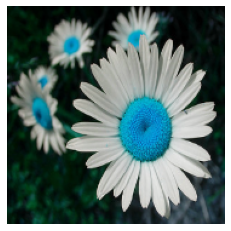

In [20]:
plt.axis('off')
plt.imshow(X_test[0])

In [30]:
y = np.expand_dims(X_test[0], axis=0)
y.shape

(1, 180, 180, 3)

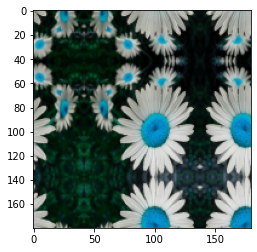

In [52]:
plt.imshow(data_augmentation(y).numpy().reshape((180,180,3)).astype("uint8"))

In [54]:
cnn_aug = models.Sequential([
    data_augmentation,
    layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same',activation='relu', input_shape=(180,180,3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same',activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same',activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')
])
cnn_aug.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [56]:
cnn.fit(X_train_scaled, y_train, epochs=1)

In [ ]:
cnn_aug.evaluate(X_test_scaled,y_test)